# Random Forest sans clustering préalable

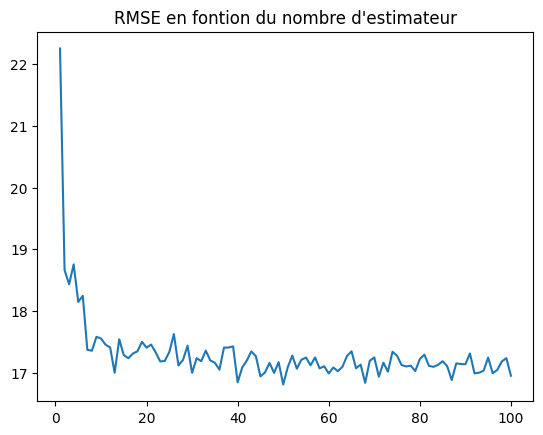

RMSE: 16.95336196540319 
MAE: 9.081909586829122 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from preprocessing import load_data, preprocess_date

pd.set_option('mode.chained_assignment', None) 

data = load_data()

# Convertir la features date en deux features mois et année
data = preprocess_date(data)

# Séparer les données d'entraînement et de test
train_data = data[data['annee'] < 2023]
test_data = data[data['annee'] == 2023]

# # Frequency encoding des gares
# frequency_encoding = train_data['gare_depart'].value_counts(normalize=True)
# train_data['gare_depart_encoded'] = train_data['gare_depart'].map(frequency_encoding)
# train_data['gare_arrivee_encoded'] = train_data['gare_arrivee'].map(frequency_encoding)
# test_data['gare_depart_encoded'] = test_data['gare_depart'].map(frequency_encoding)
# test_data['gare_arrivee_encoded'] = test_data['gare_arrivee'].map(frequency_encoding)

# Target Encoding
means_depart = train_data.groupby('gare_depart')['retard_moyen_arrivee'].mean()
train_data['gare_depart_encoded'] = train_data['gare_depart'].map(means_depart)
test_data['gare_depart_encoded'] = test_data['gare_depart'].map(means_depart)
means_arrivee = train_data.groupby('gare_arrivee')['retard_moyen_arrivee'].mean()
train_data['gare_arrivee_encoded'] = train_data['gare_arrivee'].map(means_depart)
test_data['gare_arrivee_encoded'] = test_data['gare_arrivee'].map(means_depart)

# Colonnes d'entrée
features = ['annee', 'mois', 'gare_depart_encoded', 'gare_arrivee_encoded', 'nb_train_prevu','duree_moyenne']

# Colonnes cible
target = 'retard_moyen_arrivee'

X_train_data=train_data[features]
y_train_data=train_data[target]

X_test_data=test_data[features]
y_test_data=test_data[target]


N=100
rmse_tab=np.zeros(N)
estimators=range(1,N+1)

for i in estimators:

    random_forest_model = RandomForestRegressor(n_estimators=i,max_features= 0.4, max_samples= 0.1)
    random_forest_model.fit(X_train_data, y_train_data)

    # Prédiction sur l'ensemble de test
    y_pred = random_forest_model.predict(X_test_data)

    # Évaluer la performance du modèle (par exemple, RMSE)
    rmse = mean_squared_error(y_test_data, y_pred, squared=False)
    mae = mean_absolute_error(y_test_data, y_pred)
    rmse_tab[i-1]=rmse

plt.plot(estimators, rmse_tab)
plt.title("RMSE en fontion du nombre d'estimateur")
plt.show()

print(f'RMSE: {rmse} ')
print(f'MAE: {mae} ')


On observe qu'au delà d'une cinquantaine d'estimateur, la RMSE ne diminue plus vraiment. On prendra donc n_estimators=50


In [297]:
from sklearn.model_selection import GridSearchCV
 

pgrid = {"max_samples": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
      "max_features": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

grid_search=GridSearchCV(RandomForestRegressor(n_estimators=50), param_grid=pgrid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_data, y_train_data)

# Prédiction sur l'ensemble de test
y_pred = grid_search.best_estimator_.predict(X_test_data)

# Évaluer la performance du modèle (par exemple, RMSE)
rmse = mean_squared_error(y_test_data, y_pred, squared=False)
mae = mean_absolute_error(y_test_data, y_pred)

print(f'Best model RMSE: {rmse} ')
print(f'Best model MAE: {mae} ')

print(f'Best model params: {grid_search.best_params_} ')

Best model RMSE: 17.035815489572787 
Best model MAE: 9.06861308362035 
Best model params: {'max_features': 0.4, 'max_samples': 0.1} 


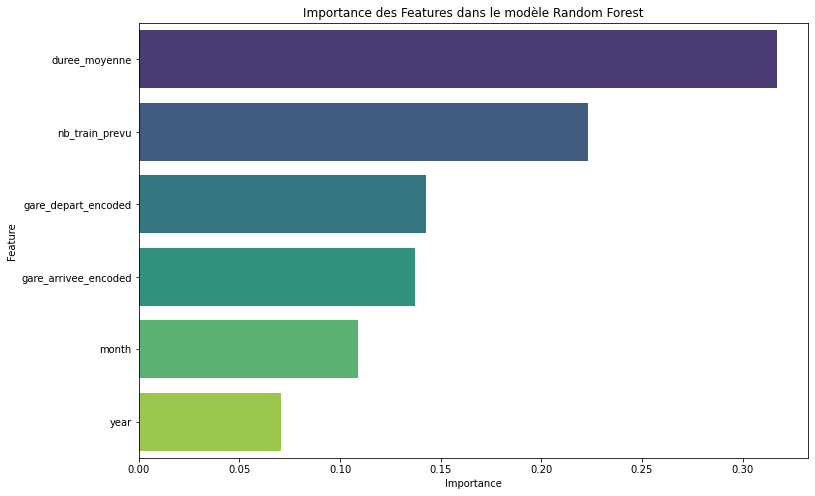

In [300]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

# Récupérer l'importance des features
feature_importances =grid_search.best_estimator_.feature_importances_
feature_names = X_train_data.columns

# Créer un DataFrame pour une visualisation plus facile
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Trier les features par importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Tracer l'importance des features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Importance des Features dans le modèle Random Forest')
plt.show()


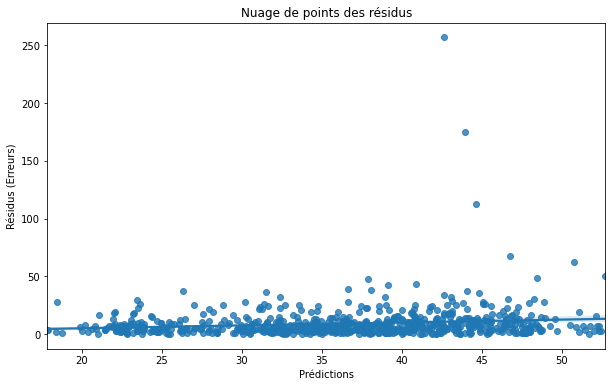

In [306]:
import matplotlib.pyplot as plt
import seaborn as sns

# Supposons que y_true et y_pred sont vos valeurs réelles et prédites respectivement
residuals = abs(y_test_data - y_pred)

# Tracer un nuage de points avec une ligne de régression
plt.figure(figsize=(10, 6))
sns.regplot(x=y_pred, y=residuals)
plt.xlabel('Prédictions')
plt.ylabel('Résidus (Erreurs)')
plt.title('Nuage de points des résidus')
plt.savefig("./figs/Nuage de points des résidus (no clustering)")
plt.show()


# Random Forest avec clustering préalable

In [371]:
data_clustering=pd.read_csv("./data_clustering.csv", sep=";")
data_clustering.head()

,Unnamed: 0,gare_depart,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,cluster,projection_x,projection_y
0,0,AIX EN PROVENCE TGV,30.140325,24.277538,16.908954,21.241538,5.036000,2.395645,0,-8.641481,-2.262358
1,1,ANGERS SAINT LAUD,26.387155,33.034993,18.498349,14.305268,4.687747,3.086487,4,-6.881333,9.234346
2,2,ANGOULEME,20.947266,33.677428,20.390078,14.350469,4.554501,6.080258,4,-3.511692,11.487730
3,3,ANNECY,30.971833,23.246582,25.669370,14.097670,4.358435,1.656110,1,0.291740,-0.114391
4,4,ARRAS,15.296356,24.102809,40.453120,12.556896,6.100829,1.489991,3,19.094243,6.497092


In [372]:
features_cause = [col for col in data.columns if col.startswith('prct')]

barycentres = data_clustering.groupby('cluster')[features_cause].mean().reset_index()


In [375]:
barycentres["somme_prct"]=barycentres[features_cause].sum(axis=1)
barycentres.head(7)

,cluster,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,somme_prct
0,0,34.362274,27.009938,14.347063,17.486294,3.901033,2.893398,100.0
1,1,24.784025,24.101965,25.526992,16.784532,5.380135,3.422352,100.0
2,2,23.216342,18.768210,20.221853,27.711864,6.211122,3.870609,100.0
3,3,19.465377,21.364340,38.377813,14.332992,4.541771,1.917706,100.0
4,4,21.563887,32.332701,19.254999,16.844980,5.125428,4.878005,100.0
5,5,30.015406,17.071848,26.025015,13.994778,7.410371,5.482581,100.0


In [389]:
resultat_moyenne=barycentres.loc[barycentres.cluster.isin([2,2])][features_cause].mean()
print(resultat_moyenne)
print(resultat_moyenne.sum())

prct_cause_externe                      23.216342
prct_cause_infra                        18.768210
prct_cause_gestion_trafic               20.221853
prct_cause_materiel_roulant             27.711864
prct_cause_gestion_gare                  6.211122
prct_cause_prise_en_charge_voyageurs     3.870609
dtype: float64
99.99999999876496


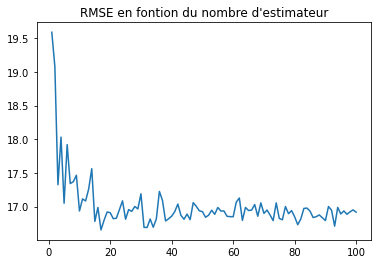

RMSE: 16.916966817692423 
MAE: 9.021132015298178 


In [428]:
data_path="./data.csv"
data = pd.read_csv(data_path, sep=';')

# On supprime les lignes où la somme des prct ne fait pas 100
features_cause = [col for col in data.columns if col.startswith('prct')]
somme_pourcentage=data[features_cause].sum(axis=1)
data = data.loc[(somme_pourcentage >= 99.9) & (somme_pourcentage <= 100.1)]

# Convertir la features date en deux features mois et année
data['date'] = pd.to_datetime(data['date'])
data['annee'] = data['date'].apply(lambda time: time.annee)
data['mois'] = data['date'].apply(lambda time: time.mois)
data=data.drop('date', axis=1)


# Séparer les données d'entraînement et de test
train_data = data[data['annee'] < 2023]
test_data = data[data['annee'] == 2023]

test_data=test_data.reset_index()

# Dans le dataset de test, on ajoute les pourcentage de causes obtenues via clustering
for col in features_cause:
    test_data[col]=None

for i in range(len(test_data)):
    instance=test_data.iloc[i]
    cluster_dep=int(data_clustering["cluster"][data_clustering.gare_depart==instance["gare_depart"]])
    cluster_arr=int(data_clustering["cluster"][data_clustering.gare_depart==instance["gare_arrivee"]])
    resultat_moyenne=barycentres.loc[barycentres.cluster.isin([cluster_dep,cluster_arr])][features_cause].mean()
    for col in features_cause:
        test_data.at[i, col]=resultat_moyenne[col]


# # Frequency encoding des gares
# frequency_encoding = train_data['gare_depart'].value_counts(normalize=True)
# train_data['gare_depart_encoded'] = train_data['gare_depart'].map(frequency_encoding)
# train_data['gare_arrivee_encoded'] = train_data['gare_arrivee'].map(frequency_encoding)
# test_data['gare_depart_encoded'] = test_data['gare_depart'].map(frequency_encoding)
# test_data['gare_arrivee_encoded'] = test_data['gare_arrivee'].map(frequency_encoding)

# Target Encoding 
means_depart = train_data.groupby('gare_depart')['retard_moyen_arrivee'].mean()
train_data['gare_depart_encoded'] = train_data['gare_depart'].map(means_depart)
test_data['gare_depart_encoded'] = test_data['gare_depart'].map(means_depart)
means_arrivee = train_data.groupby('gare_arrivee')['retard_moyen_arrivee'].mean()
train_data['gare_arrivee_encoded'] = train_data['gare_arrivee'].map(means_depart)
test_data['gare_arrivee_encoded'] = test_data['gare_arrivee'].map(means_depart)

# Colonnes d'entrée
features = ['annee', 'mois', 'gare_depart_encoded', 'gare_arrivee_encoded', 'nb_train_prevu','duree_moyenne']
features_avec_causes=features+features_cause
# Colonnes cible
target = 'retard_moyen_arrivee'

X_train_data=train_data[features_avec_causes]
y_train_data=train_data[target]

X_test_data=test_data[features_avec_causes]
y_test_data=test_data[target]


N=100
rmse_tab=np.zeros(N)
estimators=range(1,N+1)

for i in estimators:

    random_forest_model = RandomForestRegressor(n_estimators=i,max_features= 0.6, max_samples= 0.1)
    random_forest_model.fit(X_train_data, y_train_data)

    # Prédiction sur l'ensemble de test
    y_pred = random_forest_model.predict(X_test_data)

    # Évaluer la performance du modèle (par exemple, RMSE)
    rmse = mean_squared_error(y_test_data, y_pred, squared=False)
    mae = mean_absolute_error(y_test_data, y_pred)
    rmse_tab[i-1]=rmse

plt.plot(estimators, rmse_tab)
plt.title("RMSE en fontion du nombre d'estimateur")
plt.show()

print(f'RMSE: {rmse} ')
print(f'MAE: {mae} ')

In [425]:
from sklearn.model_selection import GridSearchCV
 

pgrid = {"max_samples": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
      "max_features": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

grid_search=GridSearchCV(RandomForestRegressor(n_estimators=50), param_grid=pgrid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_data, y_train_data)

# Prédiction sur l'ensemble de test
y_pred = grid_search.best_estimator_.predict(X_test_data)

# Évaluer la performance du modèle (par exemple, RMSE)
rmse = mean_squared_error(y_test_data, y_pred, squared=False)
mae = mean_absolute_error(y_test_data, y_pred)

print(f'Best model RMSE: {rmse} ')
print(f'Best model MAE: {mae} ')

print(f'Best model params: {grid_search.best_params_} ')


Best model RMSE: 16.936237498876515 
Best model MAE: 9.095622864209085 
Best model params: {'max_features': 0.6, 'max_samples': 0.1} 


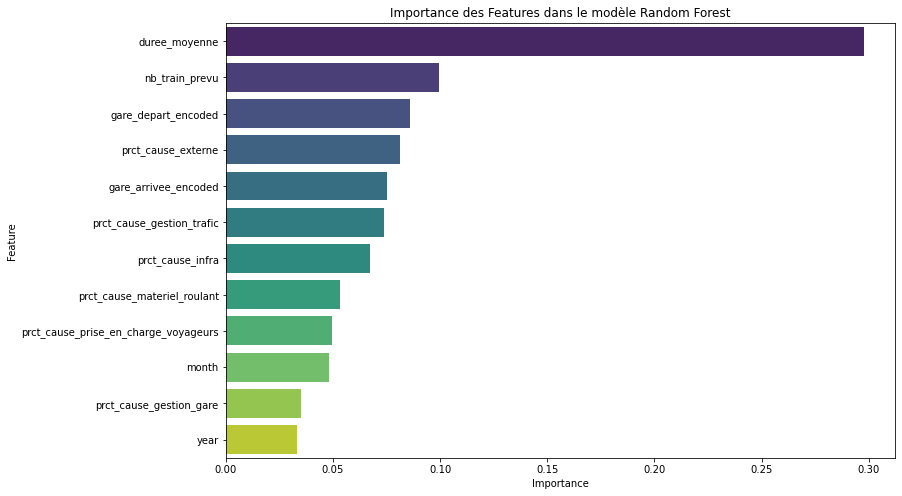

In [430]:
import matplotlib.pyplot as plt
import seaborn as sns

# Récupérer l'importance des features
feature_importances =random_forest_model.feature_importances_
feature_names = X_train_data.columns

# Créer un DataFrame pour une visualisation plus facile
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Trier les features par importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Tracer l'importance des features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Importance des Features dans le modèle Random Forest')
plt.show()
